# Project 2: Advanced Lane Finding

In this project, the goal is to write a pipeline which identifies lane boundaries in a video as well as estimating lane curvature and vehicle position with respect to center of the lane.

These steps are followed:

* First, we need to compute the camera calibration matrix and distortion coefficients from the chessboard images.

Then, the pipeline includes:
* Distortion correction.
* Color transforms, gradients, etc., to create a thresholded binary image.
* Perspective transform to rectify binary image ("birds-eye view").
* Detection of lane pixels and fitting to find the lane boundary.
* Curvature calculation of the lane and vehicle position with respect to center.
* Warp of the detected lane boundaries back onto the original image.
* Final output visualization of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages

In [1]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from PIL import ImageDraw

## Camera Calibration

We need to perform camera calibration to obtain the camera matrix and distorsion coefficients that we will then use for Distortion Correction.
* A list of calibration images stored in `./camera_cal/` is used.
* For each image, we search for chessboard corners and store them in objpoints and imgpoints if they are found.
* Having these object and image points we can then use them in `cv2.calibrateCamera()` function.

In [2]:
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [3]:
# Having object and image points we now can use cv2.calibrateCamera with shape of gray images:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

### Intrinsic Camera matrix

In [4]:
print(mtx)

[[1.15777942e+03 0.00000000e+00 6.67111050e+02]
 [0.00000000e+00 1.15282305e+03 3.86129068e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


### Distorsion Coefficients

In [5]:
print(dist)

[[-0.24688832 -0.02372817 -0.00109843  0.00035105 -0.00259133]]


## Distortion Correction

In [17]:
def undistort(img, mtx, dist):
    """
    This function applies Distortion Correction to an image.
    
    It takes the image, camera matrix and distortion coefficients,
    and returns an undistorted image.
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

## Color & Gradient Threshold
In order to define a binary thresholded image, different thresholds are used:
* Absolute value of Sobel operator in x and y direction
* Magnitude of the gradient
* Direction of the gradient

For the color thresholds I have used:
* S (Saturation) and H (Hue) thresholds from HLS color space (for better detection of yellow lines)
* L (Lightness) threshold from HLS color space (for better detection of white lines)

Other color thresholds could be used as well as other combinations of threholds in order to obtain a final binary image.

<img src="notebook_images/binary_image.png" >

In [18]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """ 
    Calculates directional gradient 
    
    It takes an image, the orientation of the gradient (x or y),
    the kernel size of the Sobel operator, and the threshold applied.
    
    It returns a binary image thesholded to the threshold given.
    """
    #Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Calculate the derivative in the x or y direction
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient=='y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    #Take the absolute value and convert to 8-bit
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    #Create a binary threshold based on gradient strength
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    """ 
    Calculates gradient magnitude
    
    It takes an image, the kernel size and the magnitude threshold.
    
    It returns a binary thresholded image
    """
    #Convert to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #Gradient in the x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    #Magnitude of the gradients
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    #Binary thresholded image
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <=mag_thresh[1])] = 1
    
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """ 
    Calculates gradient direction
    
    It takes an image, a kernel size and a threshold in radians.
    
    It returns the corresponding thresholded binary image.
    """
    #Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    #Gradient in the x and y direction
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    #Absolute value of each gradient
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    #Gradient direction
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    
    #Binary thresholded image
    dir_binary = np.zeros_like(dir_grad)
    dir_binary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    
    return dir_binary

def s_threshold(image, thresh =(0,255)):
    """
    Calculates S binary of an image
    
    It takes an image and a threshold.
    It returns the corresponding S thresholded image.
    """
    #HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #S channel
    S = hls[:,:,2]
    
    #S binary image
    s_binary = np.zeros_like(S)
    s_binary[(S >= thresh[0]) & (S <= thresh[1])] = 1
    
    return s_binary

def h_threshold(image, thresh =(0,255)):
    """
    Calculates H binary of an image
    
    It takes an image and a threshold.
    It returns the corresponding H thresholded image.
    """
    #HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #H channel
    H = hls[:,:,0]
    
    #H binary image
    h_binary = np.zeros_like(H)
    h_binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    
    return h_binary

def l_threshold(image, thresh =(0,255)):
    """
    Calculates L binary of an image
    
    It takes an image and a threshold.
    It returns the corresponding L thresholded image.
    """
    #HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    #L channel
    L = hls[:,:,1]
    #L binary image
    l_binary = np.zeros_like(L)
    l_binary[(L > thresh[0]) & (L <= thresh[1])] = 1
    return l_binary

def v_threshold(image, thresh =(0,255)):
    """
    Calculates V binary of an image
    
    It takes an image and a threshold.
    It returns the corresponding V thresholded image.
    """
    #HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #V channel
    V = hsv[:,:,2]
    
    #V binary image
    v_binary = np.zeros_like(V)
    v_binary[(V > thresh[0]) & (V <= thresh[1])] = 1
    
    return v_binary

def R_threshold(image, thresh = (0,255)):
    """
    Calculates R binary of an image
    
    It takes an image and a threshold.
    It returns the corresponding R thresholded image.
    """
    #Red channel of image
    R = image[:,:,0]
    #R binary image
    R_binary = np.zeros_like(R)
    R_binary[(R >= thresh[0]) & (R <= thresh[1])] = 1
    
    return R_binary

In [19]:
def combined(image, ksize = 3):
    """
    Combines each of the thresholding functions into one binary thresholded image 
    """
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(40, 120))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(40, 120))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
    s_binary = s_threshold(image, thresh=(90,255))
    h_binary = h_threshold(image, thresh=(15,100))
    l_binary = l_threshold(image, thresh=(200,255))
    v_binary = v_threshold(image, thresh=(50,255))
    R_binary = R_threshold(image, thresh=(200,255))
    
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) |
             (((s_binary==1)&(h_binary==1)) | (l_binary==1)) ] = 1
    
    return combined

### Color threshold for challenge video
In the challenge video there are big changes in gradient like shadows, other lines of the road... that do not belong to the lane lines. In order to solve this problem, I have only used a color threshold to only detect the white and yellow lines and delete other possible lines that may be detected.

Here is the result:

<img src="notebook_images/binary_challenge.png" >


In [20]:
def color_threshold(image):
    """
    Color threshold used in the challenge video
    """
    s_binary = s_threshold(image, thresh=(80,255))
    h_binary = h_threshold(image, thresh=(10,100))
    l_binary = l_threshold(image, thresh=(180,255))
    
    color_thresh = np.zeros_like(l_binary)
    color_thresh[((s_binary==1)&(h_binary==1)) | (l_binary==1)] = 1
    
    return color_thresh

## Perspective Transform
To obtain a perspective transfrom of an image ("bird-eye" view), four source points are selected in the original image and four destination points where these source points will appear in the warped image are also selected.

Then, we can make use of the`cv2.getPerspectiveTransform` to obtain the perspective transform M as well as the inverse perspective transfrom Minv.

Here is an example:

<img src="notebook_images/polygon.png" >

In [21]:
def warp(image):
    """
    Function that warps an image taking the Perspective Transform.
    
    The output is the warped image and the inverse perspective transform for future use.
    """
    #Image size(x_dim, y_dim)
    img_size = (image.shape[1], image.shape[0])
    
    #Source points
    src = np.float32(
        [[img_size[0]/2 - img_size[0]/3, img_size[1]],
        [img_size[0]/2 - img_size[0]/30, img_size[1]/2 + img_size[1]/8],
        [img_size[0]/2 + img_size[0]/30, img_size[1]/2 + img_size[1]/8],
        [img_size[0]/2 + img_size[0]*0.37, img_size[1]]])
    
    #Destination points
    dst = np.float32(
        [[(img_size[0]/4), img_size[1]],
        [(img_size[0]/4), 0],
        [(img_size[0] * 3/4), 0],
        [(img_size[0] * 3/4), img_size[1]]])

    #Perspective Transform
    M = cv2.getPerspectiveTransform(src, dst)
    #Inverse Perspective Transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Final warped image
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

### Perspective transform for the challenge video
I have used a different perspective transform for the challenge video. After taking a straigh line in the challenge video, here is the result:

<img src="notebook_images/polygon_challenge.png" >

In [22]:
def warp_challenge(image):
    """
    Warp function used in the challenge video.
    
    The output is the warped image and the inverse perspective transform for future use.
    """
    #Image size(x_dim, y_dim)
    img_size = (image.shape[1], image.shape[0])
    
    #Source points
    src = np.float32(
        [[img_size[0]/2 - img_size[0]*0.27, img_size[1]],
        [img_size[0]/2 - img_size[0]/40, img_size[1]/2 + img_size[1]/6],
        [img_size[0]/2 + img_size[0]/15, img_size[1]/2 + img_size[1]/6],
        [img_size[0]/2 + img_size[0]*0.4, img_size[1]]])
    
    #Destination points
    dst = np.float32(
        [[(img_size[0]/4), img_size[1]],
        [(img_size[0]/4), 0],
        [(img_size[0] * 3/4), 0],
        [(img_size[0] * 3/4), img_size[1]]])
    
    #Perspective Transform
    M = cv2.getPerspectiveTransform(src, dst)
    #Inverse Perspective Transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Final warped image
    warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, Minv

In [23]:
##################################################################################################################

In [24]:
def polygon(image_shape, path):
    """
    Helper fuction for drawing polygon formed by source points
    """
    img = Image.open(path).convert('RGBA')
    x = image_shape[1]
    y = image_shape[0]
    
    xy = (int(x/2 - x/3), int(y),
          int(x/2 - x/30), int(y/2 + y/8),
          int(x/2 + x/30), int(y/2 + y/8),
          int(x/2 + x*0.37), int(y))
    
    #Challenge video
    """
    xy = (int(x/2 - x*0.27), int(y),
          int(x/2 - x/40), int(y/2 + y/6),
          int(x/2 + x/15), int(y/2 + y/6),
          int(x/2 + x*0.4), int(y))
    """ 
    img2 = img.copy()
    draw = ImageDraw.Draw(img2)
    draw.polygon(xy, fill = "wheat")

    img3 = Image.blend(img, img2, 0.5)
    
    return img3

In [25]:
def polygon_warped(image_shape, path):
    """
    Helper fuction for drawing polygon formed by destination points
    """
    img = Image.open(path).convert('RGBA')
    x = image_shape[1]
    y = image_shape[0]
    
    xy = (int(x/4), int(y),
          int(x/4), 0,
          int(x * 3/4), 0,
          int(x * 3/4), int(y))
        
    img2 = img.copy()
    draw = ImageDraw.Draw(img2)
    draw.polygon(xy, fill = "wheat")

    img3 = Image.blend(img, img2, 0.5)
    
    return img3

## Detection of lane pixels & fitting
Having a thresholded binary image, we need to decide which pixels of the image belong to the lines as well as fitting a polynomial that represents the right and left lines.

For finding lane lines from scratch we can make use of the Sliding Windows algorithm implemented in the `find_lane_pixels()` function.

In [26]:
def find_lane_pixels(binary_warped):
    """
    Implementation of the Sliding Windows algorithm
    
    It takes the binary warped image and returns
    the pixels in the x and y position that belong
    to each line.
    """
    #Histogram of bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis = 0)

    #Output image to draw on
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    #Peaks of left and right halves of histogram(left and right lanes)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    #HYPERPARAMETERS
    #Number of sliding windows
    nwindows = 20
    #Width of the windows (+/- margin)
    margin = 50
    #Min number of pixels needed to recenter the window
    minpix = 30
    
    #Height of the windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    #x & y positions of nonzero pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #Current positions of left and right boxes
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    #Empty lists for left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    #Step through each window
    for window in range(nwindows):
        #Window boundaries
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #Draw on visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0),2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0),2)
        
        #Nonzero pixels within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        #Append inds to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        #If found pixels > minpix, recenter window
        if len(good_left_inds)>minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds)>minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    #Concatenate arrays of indices
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        pass
    
    #Left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

### Search from Prior Polynomial
If we have a confident prior polynomial estimate, we can search for the new line pixels in a margin around that polynomial instead of searching again from scratch.

To do this, the `search_around_poly()` function is used.

In [27]:
def search_around_poly(binary_warped):
    
    # We need left_fit and right_fit from last frame
    left_fit = left.current_fit
    right_fit = right.current_fit
    
    #Hyperparameter
    margin = 100
    
    #Activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                     & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                     & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    #Left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty

### Fit a polynomial
Having the pixels belonging to each line (leftx, lefty, rightx, righty) we can fit a polynomial to each lane.
The function `poly_coeff()` returns the polynomial coefficients that fit each line and the function `fit_poly()` returns x and y values for representation.

In [28]:
def poly_coeff(leftx, lefty, rightx, righty):
    #Fit a 2nd order polynomial to each lane
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        #Use last fit if unable to fit a polynomial
        left_fit = left.current_fit
        right_fit = right.current_fit
    
    return left_fit, right_fit

In [29]:
def fit_poly(img_shape, left_fit, right_fit):
    #x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except:
        #Use last values if unable to fit a line
        left_fitx = left.recent_xfitted[-1]
        right_fitx = right.recent_xfitted[-1]
    
    return left_fitx, right_fitx, ploty

## Curvature & Offset calculation
In order to measure the Radius of Curvature of each line as well as the offset of the car center from the center of the road, the `measure_curvature_offset()` function is used.

Here are also defined the conversions from pixel space to meters used in the calculation of curvature and offset as we need to give the results in meters and not in pixels.

In [30]:
#Conversions in x and y from pixel space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [31]:
def measure_curvature_offset(img_shape, ploty):
    """
    Measurement of Radius of curvature and offset
    
    The function takes the image shape and y values.
    
    It returns the Radius of curvature (mean between left and right radius)
    and the offset. Both results in meters.
    """
    #Left & right fit for real coordinates
    left_fit, right_fit = poly_coeff(left.allx*xm_per_pix, left.ally*ym_per_pix,
                                     right.allx*xm_per_pix, right.ally*ym_per_pix)
    
    y_eval = np.max(ploty)*ym_per_pix
    
    #Radius of curvature
    left_rad = ((1+(2*left_fit[0]*y_eval + left_fit[1])**2)**(3/2))/np.absolute(2*left_fit[0])
    right_rad = ((1+(2*right_fit[0]*y_eval + right_fit[1])**2)**(3/2))/np.absolute(2*right_fit[0])
    
    #Store each radius for chanity checks
    left.radius_of_curvature = left_rad
    right.radius_of_curvature = right_rad
    
    #Take average radius to return a single radius
    curve_rad = np.mean([left_rad, right_rad])
    
    #===========================#
    #     Offset calculation    #
    #===========================#
    xm = img_shape[1]*xm_per_pix
    ym = img_shape[0]*ym_per_pix
    
    x_base_left = left_fit[0]*ym**2 + left_fit[1]*ym + left_fit[2]
    x_base_right = right_fit[0]*ym**2 + right_fit[1]*ym + right_fit[2]
    
    #Store base and top positions in meters of each lane for future sanity cheks
    left.line_base_pos = x_base_left
    left.line_top_pos = left_fit[2]
    
    right.line_base_pos = x_base_right
    right.line_top_pos = right_fit[2]
    
    #Calculate lane center and img center to obtain offset
    lane_center = np.mean([x_base_left, x_base_right]) # in meters
    img_center = xm/2 # in meters
    
    offset = img_center - lane_center
    
    return curve_rad, offset

## Class Definition
With the aim of keeping track of each of the measurements in each iteration (in video processing) and for sanity checks, we define a class for each line and another class for tracking other values.

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the most recent fit
        self.current_fit = np.array([False])
        
        #radius of curvature of the line in meters
        self.radius_of_curvature = None 
        #distance in meters of lane top position (x axis,y(top))
        self.line_top_pos = None
        #distance in meters of lane base position (x axis,y(bottom))
        self.line_base_pos = None 
        
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

In [33]:
#Define a class to track other values
class last_frame():
    def __init__(self):
        #Is this the first frame?
        self.first = True
        #Number of good fits
        self.n = 0
        #Number of fail detections in a row
        self.fail = 0
        #Radius of last good frame
        self.radius = None
        #Offset of last good frame
        self.offset = None

### Class Initialization

In [34]:
# Left and Right lane classes
left = Line()
right = Line()
# Last frame class
last = last_frame()

## Pipeline
Here is the pipeline used for processing images. It performs each of the steps detailed above.

In [52]:
def pipeline(image):

    #Apply distorsion correction
    undistorted = undistort(image, mtx, dist)
    
    #Get thresholded binary image
    binary = combined(undistorted, ksize=7)

    #Apply perspective transform
    warped, Minv = warp(binary)
    
    #Finding Lane Lines
    left.allx, left.ally, right.allx, right.ally, out_img = find_lane_pixels(warped)
    
    #Polynomial coefficients
    left_fit, right_fit = poly_coeff(left.allx, left.ally, right.allx, right.ally)
    
    #Polynomial fitting
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, left_fit, right_fit)

    #Measure curvature radius & offset
    curve_rad, offset = measure_curvature_offset(warped.shape, ploty)

    #======================================================
    ################ Output visualization #################
    #======================================================
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    #Write Curvature radius and vehicle offset on the screen
    text1='Radius of Curvature = '+str(int(curve_rad))+' m'
    
    if (offset>=0):
        text2='Vehicle is '+str(round(offset,2))+'m right of center'
    else:
        text2='Vehicle is '+str(np.absolute((round(offset,2))))+'m left of center'
    
    cv2.putText(result, text1, (0+int(result.shape[1]/50) , 0+int(result.shape[0]/10)),
                fontFace=5, fontScale=2.5, color=[255,255,255], thickness=2)
    cv2.putText(result, text2, (0+int(result.shape[1]/50) , 0+int(result.shape[0]/5)),
                fontFace=5, fontScale=2.5, color=[255,255,255], thickness=2)
    
    return result
    

### Read Test Images

In [55]:
%matplotlib inline
test_images = os.listdir("./test_images/")
path = "./test_images/"+test_images[0]

image = mpimg.imread(path)
result = pipeline(image)

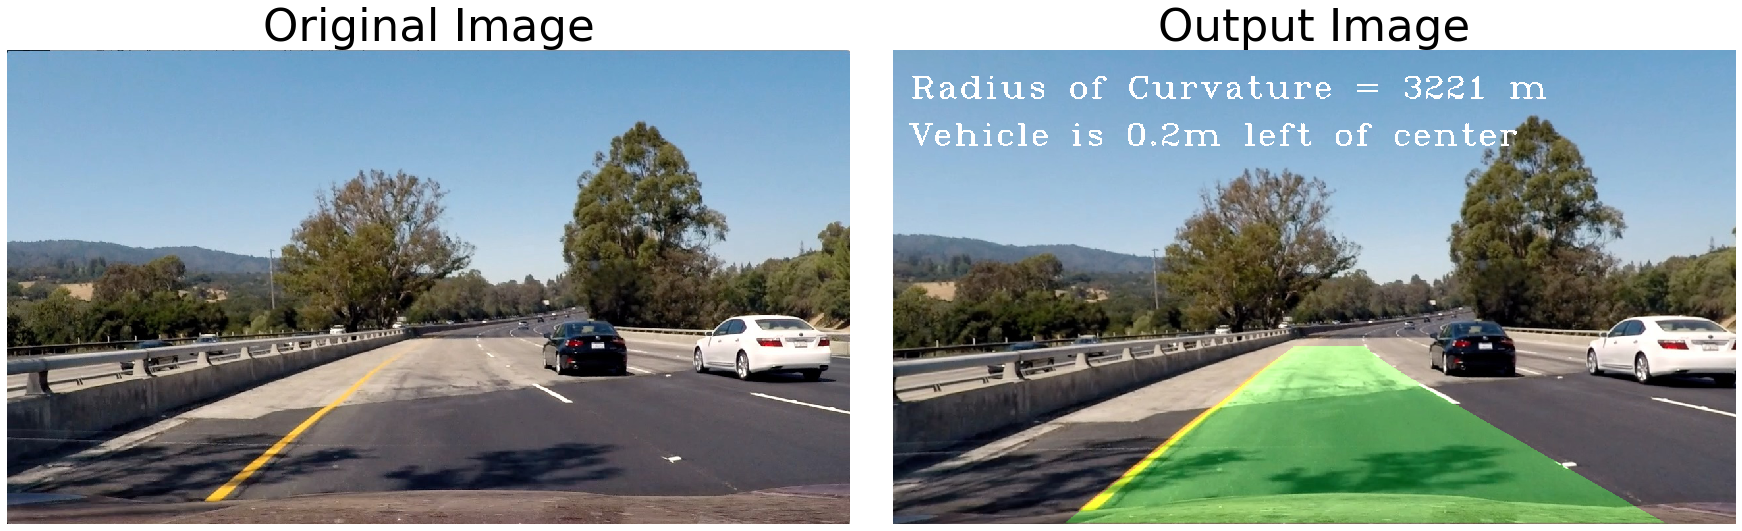

In [56]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=45)
ax1.axis("off")
ax2.imshow(result)
ax2.set_title('Output Image', fontsize=45)
ax2.axis("off")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video processing

In [164]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [169]:
# Left and Right lane classes
left = Line()
right = Line()
# Last frame class
last = last_frame()

In [170]:
def process_video(frame):

    #Apply distorsion correction
    undistorted = undistort(frame, mtx, dist)

    #Get thresholded binary image
    #binary = combined(undistorted, ksize=7)
    
    #Color threshold (for challenge video)
    binary = color_threshold(undistorted)

    #Apply perspective transform
    #warped, Minv = warp(binary)
    
    #Perspective transform for challenge video
    warped, Minv = warp_challenge(binary)

    #Check if we found lines in last frame
    if (left.detected & right.detected):
        #Search around a margin between last polynomial fit
        left.allx, left.ally, right.allx, right.ally = search_around_poly(warped)
    else:
        #Find new lines using sliding window algorithm:
        left.allx, left.ally, right.allx, right.ally, out_img = find_lane_pixels(warped)

    #Polynomial coefficients
    left_fit, right_fit = poly_coeff(left.allx, left.ally, right.allx, right.ally)
    
    left.current_fit = left_fit
    right.current_fit = right_fit
    
    #Polynomial fitting
    left_fitx, right_fitx, ploty = fit_poly(warped.shape, left_fit, right_fit)
    
    #Measure curvature radius & offset
    curve_rad, offset = measure_curvature_offset(warped.shape, ploty)
    
    #===============================================================
    ######################## SANITY CHECKS #########################
    #===============================================================
    
    #Check if lines are separated by the right distance aprox.
    base_difference = np.absolute(left.line_base_pos - right.line_base_pos)

    check1 = (base_difference > 2.7) & (base_difference < 4.2) # Usual lane length is 3.7m 
    
    #Check if lines are more or less parallel
    top_difference = np.absolute(left.line_top_pos - right.line_top_pos)
    top_base_diff = np.absolute(base_difference - top_difference)

    check2 = top_base_diff < 1 #meter

    #If Lines pass the sanity checks or this is the first frame
    if ((check1 & check2) or last.first):
        #Set left and right as detected
        left.detected = True
        right.detected = True
        
        #Consider this detection
        left.recent_xfitted.append(left_fitx)
        right.recent_xfitted.append(right_fitx)
        
        #Consider radius & offset of this frame
        last.radius = curve_rad
        last.offset = offset
        
        #Increase number of good fits
        last.n += 1
        
        #If n > 10, delete first item of list recent_xfitted for average
        if(last.n>10):
            del left.recent_xfitted[0]
            del right.recent_xfitted[0]

        #If this is first frame, set first frame to false
        if (last.first): last.first = False
            
        #Reset fail counter
        if (last.fail): last.fail=0

    elif(last.fail > 3):
        #If more than 3 fail frames in a row, set lines as not detected
        left.detected = False
        right.detected = False
    else:
        #Increase fail counter
        last.fail += 1
    
    #Consider best values for the visualization
    if(last.n>10):
        #Weighted average over last 10 frames (more weight to last frames)
        left.bestx = np.average(left.recent_xfitted, axis=0, weights=[0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.15,0.2])
        right.bestx = np.average(right.recent_xfitted, axis=0, weights=[0.05,0.05,0.05,0.1,0.1,0.1,0.1,0.1,0.15,0.2])
    else:
        #Last frame values
        left.bestx = left.recent_xfitted[-1]
        right.bestx = right.recent_xfitted[-1]
    
    left_fitx = left.bestx
    right_fitx = right.bestx
    radius = last.radius
    offset = last.offset
    
    #======================================================
    ################ Output visualization #################
    #======================================================
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (frame.shape[1], frame.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    #Write Curvature radius and vehicle offset on the screen
    text1='Radius of Curvature = '+str(int(radius))+' m'
    
    if (offset>=0):
        text2='Vehicle is '+str(round(offset,2))+'m right of center'
    else:
        text2='Vehicle is '+str(np.absolute((round(offset,2))))+'m left of center'
    
    cv2.putText(result, text1, (0+int(result.shape[1]/50) , 0+int(result.shape[0]/10)),
                fontFace=5, fontScale=2.5, color=[255,255,255], thickness=2)
    cv2.putText(result, text2, (0+int(result.shape[1]/50) , 0+int(result.shape[0]/5)),
                fontFace=5, fontScale=2.5, color=[255,255,255], thickness=2)
    
    return result

### Project Video

In [167]:
project_video_output = 'output_videos/project_video_output.mp4'

clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_video)
%time project_clip.write_videofile(project_video_output, audio=False)

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/project_video_output.mp4.
Moviepy - Writing video output_videos/project_video_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video_output.mp4
CPU times: user 13min 44s, sys: 1min 46s, total: 15min 30s
Wall time: 7min 1s


### Challenge Video

In [171]:
challenge_video_output = 'output_videos/challenge_video_output.mp4'

clip2 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip2.fl_image(process_video)
%time challenge_clip.write_videofile(challenge_video_output, audio=False)

t:   0%|          | 0/485 [00:00<?, ?it/s, now=None]

Moviepy - Building video output_videos/challenge_video_output.mp4.
Moviepy - Writing video output_videos/challenge_video_output.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video_output.mp4
CPU times: user 2min 3s, sys: 14 s, total: 2min 17s
Wall time: 1min
